In [59]:
import scipy.io as sio
import numpy as np
import torch
import glob
from core.models.utils.evaluation import eval_atc_all
import trimesh
import os
import matplotlib.pyplot as plt
from transforms3d.euler import euler2mat
os.environ["PYOPENGL_PLATFORM"] = "osmesa"
import pyrender


def generate_mesh(point, color1, color2=None, mask=0, weight=0, split=False):
    sm = trimesh.creation.uv_sphere(radius=0.01, count=[6,6])
    nv = sm.vertices.shape[0]
    vtx, faces, tex = [], [], []
    print(point.shape[0])
    
    for i in range(point.shape[0]):
        vtx.append(sm.vertices.copy() + point[i])
        faces.append(sm.faces.copy() + i * nv)
        if not split:
            tex.append(np.ones_like(vtx[-1]) * color1)
        else:
            if type(mask) != int:
                if mask[i]:
                    tex.append(np.ones_like(vtx[-1]) * color2)
                else:
                    tex.append(np.ones_like(vtx[-1]) * color1)
            if type(weight) != int:
                color = color1 * weight[i] + color2 * (1 - weight[i])
                tex.append(np.ones_like(vtx[-1]) * color * 0.99)
    vtx = np.concatenate(vtx, axis=0)
    faces = np.concatenate(faces, axis=0)
    tex = np.concatenate(tex, axis=0)
    mesh = trimesh.Trimesh(vertices=vtx, faces=faces, vertex_colors=tex)
    return mesh

In [92]:
ditto_data_path = '/nhome/yuchen_che/ditto_dataset/train/microwave_train_1K/scenes/'
data = np.load(ditto_data_path + 'a24e299bf36c44308bf5aa6f29bd08bf.npz', allow_pickle=True)
data.files

['pc_start',
 'pc_start_end',
 'pc_seg_start',
 'pc_end',
 'pc_end_start',
 'pc_seg_end',
 'state_start',
 'state_end',
 'screw_axis',
 'screw_moment',
 'joint_type',
 'joint_index',
 'start_p_occ',
 'start_occ_list',
 'end_p_occ',
 'end_occ_list',
 'start_mesh_pose_dict',
 'end_mesh_pose_dict',
 'object_path']

In [104]:
data['pc_start'].var(axis=0).mean()

0.0010197980123996125

0.08285890337932757

In [28]:
data['pc_seg_start']

array([ True,  True,  True, ..., False, False, False])

In [34]:
data['screw_axis']

array([ 0.99075108, -0.13569191,  0.        ])

In [61]:
np.cross(data['screw_axis'], data['screw_moment'])

array([0.0187519 , 0.13691655, 0.12248703])

In [68]:
data['start_mesh_pose_dict'].item()['0_0'][0][1]

(0.1020087075005529, 0.1020087075005529, 0.1020087075005529)

In [70]:
data['state_start']

array(0.28460695)

In [89]:
#path = '/nhome/yuchen_che/ditto/data/syn/microwave_train_1K/scenes/'
path = '/nhome/yuchen_che/ditto/data/syn/cabinet2_rand_train_1K/scenes/'
instance_list = glob.glob(path+'*.npz')
for i in instance_list:
    data = np.load(i, allow_pickle=True)
    if data['joint_type'] != 0:
        print(i)

s2m:
    faucet, laptop, oven
syn:
    cabinet2, microwave, toaster

In [41]:
result_path = glob.glob("/nhome/yuchen_che/ditto/result/Ditto_single_joint_mix-13-51-10/results/*")

In [122]:
overall_iou = 0
orientation = 0
distance = 0

for result_instance in result_path:
    result_instance += '/quant.npz'
    result = np.load(result_instance, allow_pickle=True)

    direction_hat = result['output'].item()['joint_axis'][np.newaxis, ...]
    location_hat = result['output'].item()['pivot_point'][np.newaxis, ...]
    #segmentation_hat = np.concatenate([result['segmentation'].item()['hat_start'][np.newaxis, ...], result['segmentation'].item()['hat_end'][np.newaxis, ...]],axis = 0)
    segmentation_hat = result['segmentation'].item()['hat_start'][np.newaxis, ...]
    segmentation_hat = segmentation_hat[..., np.newaxis].repeat(2, axis=-1)
    segmentation_hat[..., -1] = ~segmentation_hat[..., -1]

    direction_gt = result['data'].item()['joint_axis'][np.newaxis, ...]
    location_gt = result['data'].item()['pivot_point'][np.newaxis, ...]
    #segmentation_gt = np.concatenate([result['segmentation'].item()['GT_start'][np.newaxis, ...], result['segmentation'].item()['GT_end'][np.newaxis, ...]],axis = 0)
    segmentation_gt = result['segmentation'].item()['GT_start'][np.newaxis, ...]
    segmentation_gt = segmentation_gt[..., np.newaxis]

    eval_result = eval_atc_all(direction_hat, location_hat, segmentation_hat, direction_gt, location_gt, segmentation_gt)
    print(result_instance.split('/')[-2:-1], eval_result['overall_iou'], eval_result['joint_orientation_error_mean'], eval_result['joint_distance_error'])
    #print(direction_gt)
    overall_iou += eval_result['overall_iou']
    orientation += eval_result['joint_orientation_error_mean']
    distance += eval_result['joint_distance_error']

overall_iou /= len(result_path)
orientation /= len(result_path)
distance /= len(result_path)

['0027'] 0.9620966797661127 [0.29936148] [[0.01948286]]
['0017'] 0.9822608357631677 [0.61453048] [[0.0162292]]
['0016'] 0.9892484636547756 [0.84116421] [[0.01351474]]
['0000'] 0.9376275214991194 [0.44455393] [[0.04682701]]
['0013'] 0.9902866272144599 [0.66910326] [[0.01919058]]
['0026'] 0.9600518479224498 [1.03759752] [[0.02812065]]
['0024'] 0.9660241148674198 [1.27625574] [[0.02333264]]
['0009'] 0.9846972802480805 [1.11504695] [[0.02268699]]
['0011'] 0.985963166478568 [0.8629809] [[0.01782529]]
['0006'] 0.9371652394486345 [0.16432452] [[0.0332907]]
['0014'] 0.9848901363037835 [0.63334717] [[0.01334928]]
['0020'] 0.9794010133237776 [2.36554381] [[0.02776684]]
['0012'] 0.9841044204080379 [0.54679688] [[0.01666504]]
['0021'] 0.9798905580418882 [1.84281279] [[0.01382328]]
['0019'] 0.9928126784631981 [0.79228844] [[0.01931273]]
['0005'] 0.9590083500654722 [0.35936467] [[0.04082318]]
['0003'] 0.9424150409290628 [0.63365602] [[0.05994348]]
['0004'] 0.9451575733261116 [1.93643888] [[0.0382826

In [123]:
overall_iou, orientation, distance

(0.9701638273613229, array([0.85071986]), array([[0.02411262]], dtype=float32))

In [119]:
result = np.load("/nhome/yuchen_che/ditto/result/Ditto_single_joint_mix-13-51-10/results/0021/quant.npz", allow_pickle=True)

In [120]:
pc_start = result['segmentation'].item()['pc_start'].cpu().numpy()
pc_end = result['segmentation'].item()['pc_end'].cpu().numpy()
label_start = result['segmentation'].item()['hat_start']
label_end = result['segmentation'].item()['hat_end']

8192
8192


(-0.5, 479.5, 479.5, -0.5)

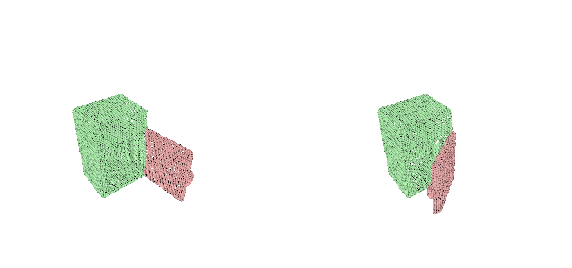

In [121]:
mesh_start = generate_mesh(
    pc_start,
    color2=np.array([1,0.5,0.5]),
    color1=np.array([0.5,1,0.5]),
    #weight=cham_x[b,p].flatten(),
    mask=label_start,
    split=True)
mesh_end = generate_mesh(
    pc_end,
    color2=np.array([1,0.5,0.5]),
    color1=np.array([0.5,1,0.5]),
    #weight=cham_x[b,p].flatten(),
    mask=label_end,
    split=True)

R = euler2mat(-0.*np.pi, 0.3*np.pi, -0.2*np.pi, "rzyx")
camera_pose = np.eye(4)
camera_pose[:3, :3] = R
camera_pose[:3, 3] = np.array([-0.,0.2,2])
camera_pose[:3, 3:4] = R @ camera_pose[:3, 3:4]
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3, aspectRatio=1.0,)
light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=4.0)

r = pyrender.OffscreenRenderer(480, 480)
scene_mask = pyrender.Scene()
scene_mask.add(pyrender.Mesh.from_trimesh(mesh_start, material=None))
scene_mask.add(camera, pose=camera_pose)
scene_mask.add(light, pose=camera_pose)
color_mask_1, depth = r.render(scene_mask)
scene_mask = pyrender.Scene()
scene_mask.add(pyrender.Mesh.from_trimesh(mesh_end, material=None))
scene_mask.add(camera, pose=camera_pose)
scene_mask.add(light, pose=camera_pose)
color_mask_2, depth = r.render(scene_mask)

plt.figure(figsize=(10, 20))
plt.subplot(1,2,1)
plt.imshow(color_mask_1)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(color_mask_2)
plt.axis('off')